In [30]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
import torch
import torchvision
import torchvision.transforms as transforms

Select a set of grayscale images (e.g., faces, landscapes, or any other category). Normalize the images by scaling pixel values to a range [0, 1].

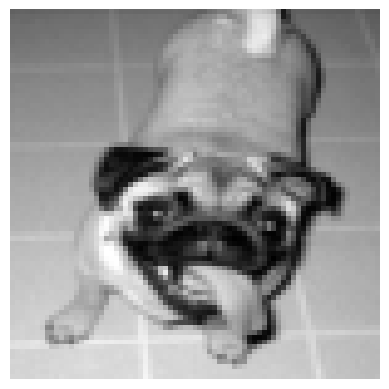

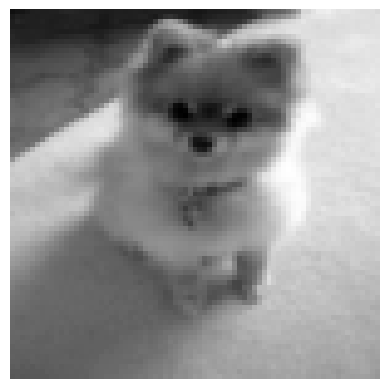

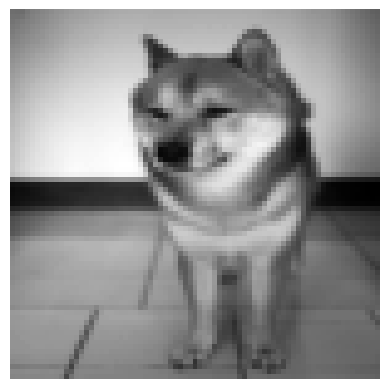

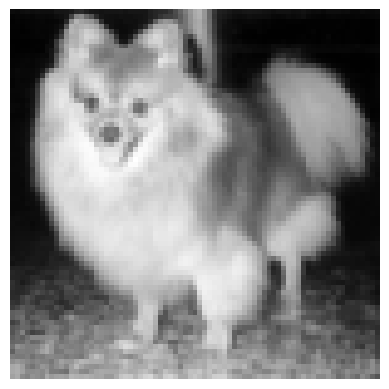

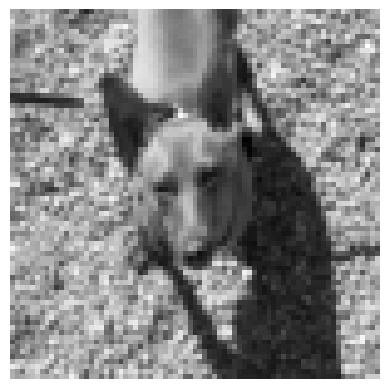

In [31]:
height = width = 75

transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor
])

# Load the Oxford Pets dataset
trainset = torchvision.datasets.OxfordIIITPet(root='../data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Initialize a list to store normalized images
normalized_images = []


# Iterate over the data loader
for images, labels in trainloader:
    # Normalize images to [0, 1]
    normalized_images.append(images.numpy())  # Store as numpy array for easier handling
    break  # Get only the first batch for demonstration

# Flatten the list to get all images in one array
normalized_images = np.concatenate(normalized_images, axis=0)

# Function to show an image
def imshow(img):
    img = img[0]  # Get the first channel (grayscale)
    plt.imshow(img, cmap='gray')  # Use gray colormap for grayscale
    plt.axis('off')  # Hide axes
    plt.show()

# Show some of the normalized images
for i in range(5):  # Display first 5 images
    imshow(normalized_images[i])


# PCA Implementation
Write a Python function to perform PCA on the images. Implement the following steps:

### Convert the image into a 2D matrix where each row represents an image and each column represents a pixel value.

In [32]:
flattened_images = [img.flatten() for img in normalized_images]

# Convert the list of flattened images into a 2D NumPy array
image_matrix = np.stack(flattened_images)

# Verify the shape of the resulting matrix
print(f"Image matrix shape: {image_matrix.shape}")  # Shape should be (num_images, height * width)

# Optional: Print the first few rows of the matrix to verify
print(image_matrix[:2, :10])  # First 2 images, first 10 pixel values (just for a small preview)


Image matrix shape: (100, 5625)
[[0.39215687 0.39607844 0.4        0.39607844 0.3882353  0.39607844
  0.4        0.40392157 0.4        0.40392157]
 [0.12941177 0.14117648 0.14509805 0.16470589 0.18039216 0.18431373
  0.18039216 0.18039216 0.18431373 0.18431373]]


### Compute the covariance matrix of the image data.

In [33]:
# Step 1: Center the image data by subtracting the mean of each column (pixel)
mean_image = np.mean(image_matrix, axis=0)
centered_matrix = image_matrix - mean_image

# Step 2: Compute the covariance matrix of the centered data
# Covariance matrix: (1 / (n - 1)) * X^T * X where X is the centered data matrix
cov_matrix = np.cov(centered_matrix, rowvar=False)

# Step 3: Verify the shape of the covariance matrix
print(f"Covariance matrix shape: {cov_matrix.shape}")

# Optional: Print a small part of the covariance matrix for inspection
print(cov_matrix[:5, :5])  # Print the top-left 5x5 block


Covariance matrix shape: (5625, 5625)
[[0.07107119 0.0652886  0.06494696 0.06480778 0.06621134]
 [0.0652886  0.06592725 0.06482258 0.06296668 0.06355896]
 [0.06494696 0.06482258 0.06881173 0.06923837 0.06841708]
 [0.06480778 0.06296668 0.06923837 0.07223064 0.07091502]
 [0.06621134 0.06355896 0.06841708 0.07091502 0.07243422]]


### Calculate the eigenvalues and eigenvectors of the covariance matrix.

In [34]:
# Step 1: Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)



### Sort the eigenvectors based on the eigenvalues in descending order

In [35]:
# Step 2: Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of sorted eigenvalues in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Step 3: Print the top 5 eigenvalues for inspection
print(f"Top 5 eigenvalues: {sorted_eigenvalues[:5]}")

# Optional: Print the shape of the sorted eigenvectors
print(f"Eigenvectors shape: {sorted_eigenvectors.shape}")

Top 5 eigenvalues: [85.95271712 38.04782313 25.22359872 21.74395752 16.2454495 ]
Eigenvectors shape: (5625, 5625)


### Select the top k eigenvectors to form the principal components.

In [68]:
# Choose the number of principal components (k)
k = 75  # You can adjust this based on how many components you want

# Select the top k eigenvectors (principal components)
top_k_eigenvectors = sorted_eigenvectors[:, :k]

# Print the selected principal components
print(f"Top {k} eigenvectors (Principal Components):")
print(top_k_eigenvectors)


Top 75 eigenvectors (Principal Components):
[[-0.01466892  0.01236841  0.00675842 ... -0.01111745  0.00446338
   0.00115927]
 [-0.01452738  0.01152888  0.00670701 ...  0.00589606 -0.00159279
   0.01325841]
 [-0.01511961  0.01276753  0.00446161 ...  0.00668949 -0.00928458
   0.00660965]
 ...
 [-0.01585642 -0.01333872 -0.01966759 ... -0.01194752  0.00501124
   0.01847616]
 [-0.01572833 -0.01277409 -0.01902033 ... -0.00872525  0.00263854
   0.01800065]
 [-0.0152725  -0.01204916 -0.02063001 ... -0.01458882  0.01103002
   0.02197953]]


### Project the original images onto the lower-dimensional subspace defined by the selected principal components.

In [69]:
# Step 1: Flatten the original normalized images (if not done already)
flattened_images = [image.flatten() for image in normalized_images]

# Step 2: Stack the flattened images into a 2D matrix
image_matrix = np.stack(flattened_images)

# Step 3: Project the original data onto the top k eigenvectors (principal components)
projected_data = np.dot(image_matrix, top_k_eigenvectors)

# Step 4: Print the projected data shape (verification)
print(f"Projected data shape: {projected_data.shape}")

# Optional: Print the projected data
print(projected_data)


Projected data shape: (100, 75)
[[-4.03177192e+01 -1.49241448e+01  3.86019119e+00 ... -5.51590958e-01
   9.05619490e-01 -8.59319893e-02]
 [-3.95660137e+01 -1.03462254e+01  5.63076595e-01 ...  1.22029926e-01
   7.97594970e-01  1.39798331e-01]
 [-3.22271534e+01 -8.70489880e+00  1.17140772e+01 ...  6.44495433e-01
  -2.87721421e-01  3.26805905e-01]
 ...
 [-1.44745513e+01 -7.76671501e+00  1.72634056e-02 ...  5.71302205e-01
   1.06506096e+00 -1.67056742e+00]
 [-1.91916597e+01 -8.60164706e+00  1.32161549e+01 ...  1.19674683e-01
   7.51591900e-01 -1.82936285e-01]
 [-2.35729428e+01 -1.53393219e+01  1.10314612e+01 ... -8.72532679e-02
   1.28684977e+00  3.98500630e-01]]


# Reconstruction of Images

### Using the selected principal components, reconstruct the images.

In [70]:
# Step 1: Reconstruct the images by projecting back into the original space
reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)

# Step 2: Reshape the reconstructed data to form the images
reconstructed_images = [reconstructed_image.reshape((height, width)) for reconstructed_image in reconstructed_images]

# Step 3: Print the shape of the reconstructed images to verify
print(f"Reconstructed images shape: {reconstructed_images[0].shape}")

# Display original and reconstructed images side by side for comparison



Reconstructed images shape: (75, 75)


### Compare the reconstructed images with the original images to observe the effects of dimensionality reduction.

100


<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Original Image 1')

(np.float64(-0.5), np.float64(74.5), np.float64(74.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Reconstructed Image 1')

(np.float64(-0.5), np.float64(74.5), np.float64(74.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Original Image 2')

(np.float64(-0.5), np.float64(74.5), np.float64(74.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Reconstructed Image 2')

(np.float64(-0.5), np.float64(74.5), np.float64(74.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Original Image 3')

(np.float64(-0.5), np.float64(74.5), np.float64(74.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'Reconstructed Image 3')

(np.float64(-0.5), np.float64(74.5), np.float64(74.5), np.float64(-0.5))

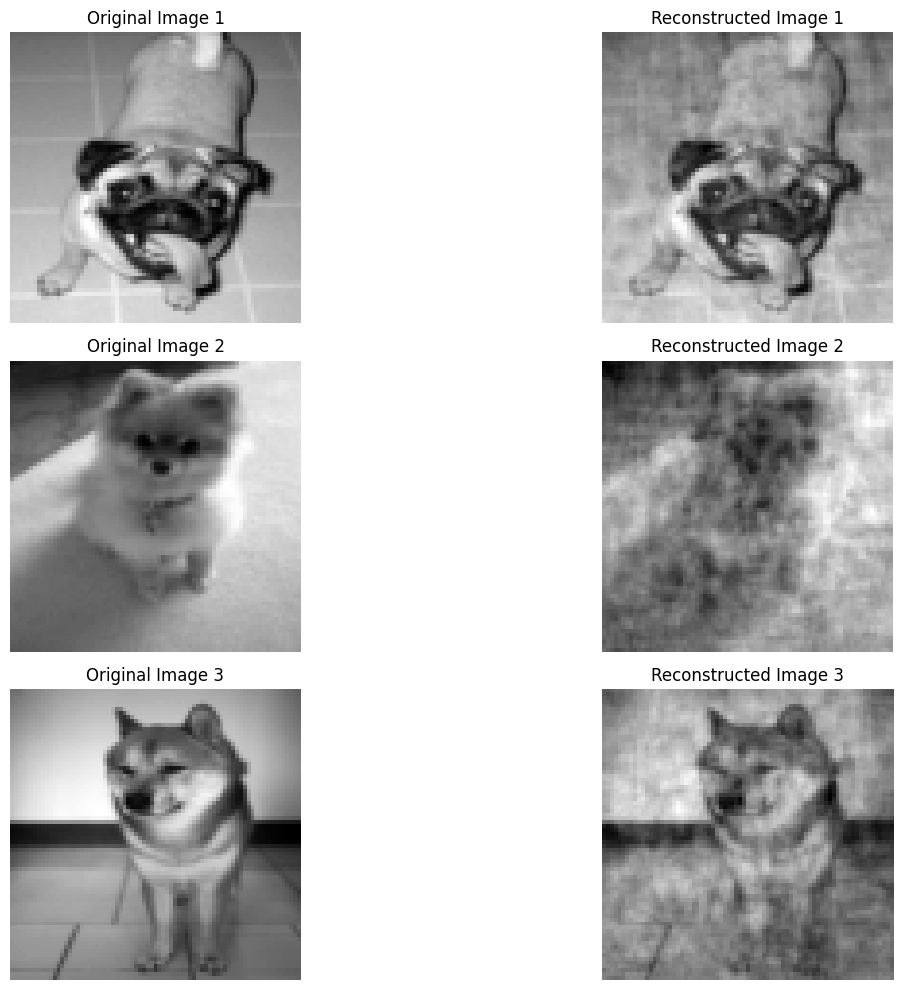

In [73]:
num_images = 3  # Set this to the number of images you want to display
image_shape = (height, width)  # Assuming square images
print(len(reconstructed_images))
# Create a figure with subplots
plt.figure(figsize=(15, 10))

for i in range(num_images):
    # Original image
    plt.subplot(num_images, 2, 2 * i + 1)  # Odd index for original images
    plt.imshow(flattened_images[i].reshape(image_shape), cmap='gray')
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')  # Hide axes for better visualization

    # Reconstructed image
    plt.subplot(num_images, 2, 2 * i + 2)  # Even index for reconstructed images
    plt.imshow(reconstructed_images[i].reshape(image_shape), cmap='gray')
    plt.title(f'Reconstructed Image {i + 1}')
    plt.axis('off')  # Hide axes for better visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Experimentation

### Vary the number of principal components (k) and observe the impact on the quality of the reconstructed images.

### Plot the variance explained by the principal components and determine the optimal number of components that balances compression and quality

# Visual Analysis

### Display the original images alongside the reconstructed images for different values of k.

### Comment on the visual quality of the images and how much information is lost during compression.

# Error Analysis

### Compute the Mean Squared Error (MSE) between the original and reconstructed images.

### Analyze the trade-off between compression and reconstruction error.